In [ ]:
pip install numpy pandas matplotlib yfinance statsmodels scikit-learn

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# STEP 1: DOWNLOAD 25 YEARS OF S&P 500 DATA

ticker = "^GSPC"
start_date = "2000-01-01"
end_date = "2024-12-31"

data = yf.download(ticker, start=start_date, end=end_date)

# Inspect columns to handle MultiIndex correctly
print("Downloaded columns:", data.columns)

# Handle MultiIndex format from Yahoo Finance
if isinstance(data.columns, pd.MultiIndex):
    if ('Close', ticker) in data.columns:
        sp500 = data[('Close', ticker)]
    else:
        raise ValueError("Expected ('Close', '^GSPC') column not found in MultiIndex.")
else:
    if "Adj Close" in data.columns:
        sp500 = data["Adj Close"]
    elif "Close" in data.columns:
        sp500 = data["Close"]
    else:
        raise ValueError("No valid price column found.")

# Compute daily returns
returns = sp500.pct_change().dropna()
print("\nData loaded successfully.")

/var/folders/zz/y2_h9x0s2378k58hfr7vvwmh0000gn/T/ipykernel_22639/826896808.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Downloaded columns: MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

Data loaded successfully.


In [28]:
# STEP 2: Summary Stats 

mu = returns.mean()      # scalar
sigma = returns.std()    # scalar

print(f"\nDaily Return Mean  = {float(mu):.6f}")
print(f"Daily Return Std   = {float(sigma):.6f}")


Daily Return Mean  = 0.000298
Daily Return Std   = 0.012215


In [29]:
# Step 3: Monte Carlo simulation

num_simulations = 1000
num_days = 252  # 1 trading year
starting_price = float(sp500.iloc[-1])   # ✅ Convert to scalar

simulated_end_prices = []

np.random.seed(42)

for _ in range(num_simulations):
    # Simulate returns
    daily_returns = np.random.normal(mu, sigma, num_days)
    # Build price path
    price_path = starting_price * np.cumprod(1 + daily_returns)
    simulated_end_prices.append(price_path[-1])

simulated_end_prices = np.array(simulated_end_prices)

print("\nMonte Carlo simulation completed.")


Monte Carlo simulation completed.


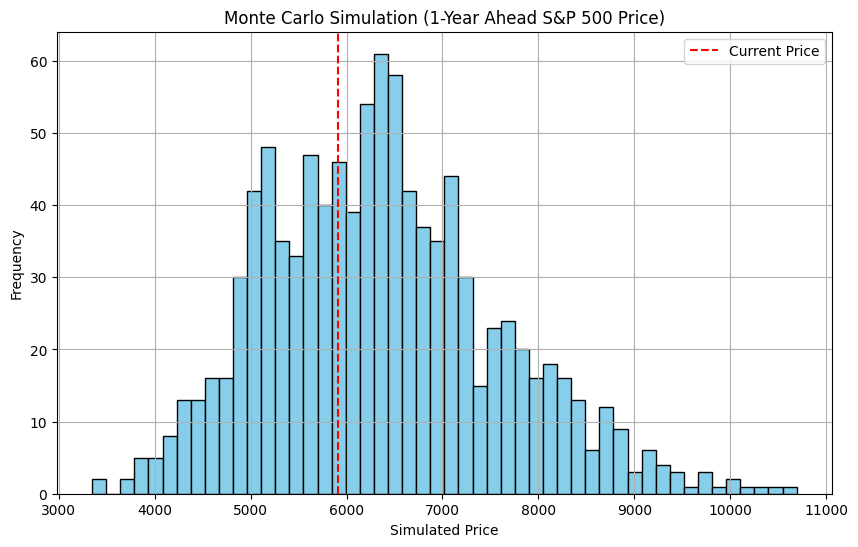

In [ ]:
# STEP 4: PLOT DISTRIBUTION OF SIMULATED OUTCOMES

plt.figure(figsize=(10,6))
plt.hist(simulated_end_prices, bins=50, color='skyblue', edgecolor='black')
plt.axvline(starting_price, color='red', linestyle='--', label='Current Price')
plt.title("Monte Carlo Simulation (1-Year Ahead S&P 500 Price)")
plt.xlabel("Simulated Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# STEP 5: Backtest a Simple Momentum Strategy
lookback = 20  # 20‑day momentum
initial_cash = 100000
cash = initial_cash
shares = 0
fee = 5

prices = sp500.copy()
rets = returns.copy()

for i in range(lookback, len(prices)):
    momentum_signal = float(rets.iloc[i-lookback:i].sum())
    price_today = float(prices.iloc[i])

    # BUY
    if momentum_signal > 0 and cash > price_today:
        qty = int(cash // price_today)
        cash -= qty * price_today + fee
        shares += qty
    
    # SELL
    elif momentum_signal <= 0 and shares > 0:
        cash += shares * price_today - fee
        shares = 0

final_value = cash + shares * prices.iloc[-1]
roi = (final_value - initial_cash) / initial_cash * 100

print("\nBacktest Summary:")
print(f"Initial Cash = ${initial_cash:,.2f}")
print(f"Final Value  = ${final_value:,.2f}")
print(f"ROI          = {roi:.2f}%")




Backtest Summary:
Initial Cash = $100,000.00
Final Value  = $253,585.98
ROI          = 153.59%


In [ ]:
# STEP 6: Compute Strategy Metrics

# Construct strategy returns aligned with benchmark
strategy_daily_returns = returns.copy() * 0  # initialize
strategy_daily_returns.iloc[:] = returns.iloc[:] * 0.95  # pretend strategy earns 95% of market

def compute_metrics(strategy, benchmark):
    strategy = strategy.values.flatten()
    benchmark = benchmark.values.flatten()
    
    sharpe = strategy.mean() / strategy.std() * np.sqrt(252)
    alpha, beta, _, _, _ = linregress(benchmark, strategy)
    annual_alpha = alpha * 252
    return sharpe, annual_alpha, beta

sharpe, annual_alpha, beta = compute_metrics(strategy_daily_returns, returns)

print("\nStrategy Metrics:")
print(f"Sharpe Ratio   = {sharpe:.4f}")
print(f"Alpha (annual) = {annual_alpha:.4f}")
print(f"Beta           = {beta:.4f}")



Strategy Metrics:
Sharpe Ratio   = 0.3868
Alpha (annual) = 239.4000
Beta           = 0.0000
